# Column Generation


In [1]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from exputils.Amat.get import get_Amat_sparse
from exputils.extent.custom import calculate_extent_custom
from exputils.state.random_ket import make_random_quantum_state
from exputils.extent.actual import calculate_extent_actual

In [11]:
from exputils.math.q_binom import q_binomial
from exputils.stabilizer_group import total_stabilizer_group_size


n = 10
cnt = 1 << n
for k in range(1, n + 1):
    print(f"{n=} {k=} {q_binomial(n,k)=}")
    term = q_binomial(n, k) * (1 << (n - k + k + k * (k + 1) // 2))
    cnt += term
print(cnt)
print(total_stabilizer_group_size(n))
print(1 << 64)

n=10 k=1 q_binomial(n,k)=1023
n=10 k=2 q_binomial(n,k)=174251
n=10 k=3 q_binomial(n,k)=6347715
n=10 k=4 q_binomial(n,k)=53743987
n=10 k=5 q_binomial(n,k)=109221651
n=10 k=6 q_binomial(n,k)=53743987
n=10 k=7 q_binomial(n,k)=6347715
n=10 k=8 q_binomial(n,k)=174251
n=10 k=9 q_binomial(n,k)=1023
n=10 k=10 q_binomial(n,k)=1
87876754128408960000
87876754128408960000
18446744073709551616


In [8]:
from collections import Counter
from exputils.dot.get_topK_Amat import get_topK_Amat
import seaborn as sns

sns.set_theme("paper")
rc = {"mathtext.fontset": "stix"}
plt.rcParams.update(rc)


def visualize_result(n_qubit, extends, max_values):
    fig = plt.figure(figsize=(6.5, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    # plot extends to ax1 with seaborn
    sns.lineplot(x=list(range(1, len(extends) + 1)), y=extends, ax=ax1, marker="o")
    ax1.set_xlabel("Iteration", fontsize=25)
    ax1.set_ylabel("Objective Value", fontsize=25)
    ax1.set_xticks(list(range(1, len(extends) + 1)))
    ax1.set_title(f"$n = {n_qubit}$", fontsize=25)
    sns.lineplot(
        x=list(range(1, len(max_values) + 1)), y=max_values, ax=ax2, marker="o"
    )
    ax2.set_xlabel("Iteration", fontsize=25)
    ax2.set_ylabel("Max Violation", fontsize=25)
    ax2.set_xticks(list(range(1, len(max_values) + 1)))
    ax2.set_title(f"$n = {n_qubit}$", fontsize=25)
    fig.suptitle("(a)" if n_qubit == 7 else "(b)", fontsize=25, y=0.85, x=0.05)
    plt.tight_layout()
    # plt.savefig(f"CG_{n_qubit}.pdf", bbox_inches="tight")
    # plt.close()
    plt.show()


def CG(n: int, psi: np.ndarray, K: float, method: str = "mosek"):
    print(f"CG: {n=}, {K=}, {method=}")
    print("start: calculate dots")
    current_Amat = get_topK_Amat(n, psi, False)
    iter_max = 100
    eps = 1e-8
    discard_current_threshold = 0.8
    violation_max = 10000
    extends = []
    max_values = []
    for it in range(iter_max):
        print(f"iteration: {it + 1} / {iter_max}, Amat.shape = {current_Amat.shape}")
        print("start: solve SOCP")
        stabilizer_extent, coeff, dual = calculate_extent_custom(
            n, current_Amat, psi, method
        )
        extends.append(stabilizer_extent)
        print(f"{stabilizer_extent=}")
        print("start: calculate dual dots")
        dual_dots_state = get_topK_Amat(n, dual, True)
        dual_dots = np.abs(dual.conj().T @ dual_dots_state)
        dual_violated_indices = dual_dots > 1 + eps
        violated_count = np.sum(dual_violated_indices)
        max_values.append(max(1.0, np.max(dual_dots)))
        print(
            f"# of violations: {violated_count}"
            + ("+ more" if violated_count == 5000 else "")
        )

        # restrict current Amat
        nonbasic_indices = np.abs(coeff) > eps
        critical_indices = np.abs(dual @ current_Amat) >= (
            discard_current_threshold - eps
        )
        remain_indices = np.logical_or(nonbasic_indices, critical_indices)
        current_Amat = current_Amat[:, remain_indices]

        if violated_count == 0:
            print("OPTIMAL!")
            break
        extra_size = min(violation_max, violated_count)
        extra_Amat = dual_dots_state[
            :, np.argpartition(dual_dots, -extra_size)[-extra_size:]
        ]
        print(f"{current_Amat.shape=}, {extra_Amat.shape=}")
        if extra_Amat.shape[1] <= 1:
            print(extra_Amat.toarray())
        current_Amat = scipy.sparse.hstack([current_Amat, extra_Amat])

    print(f"{Counter(np.count_nonzero(current_Amat.toarray(), axis=0))=}")
    return stabilizer_extent, extends, max_values

In [9]:
n = 4
for seed in range(3):
    print("=" * 20)
    np.random.seed(seed)
    psi = make_random_quantum_state("pure", n, seed)
    psi_check = psi.copy()
    stabilizerExtent = CG(n, psi, 0.01)[0]
    print(f"{stabilizerExtent=}")
    stabilizerExtent_check = calculate_extent_actual(n, psi)[0]
    print(f"{stabilizerExtent_check=}")
    assert np.allclose(psi, psi_check, atol=1e-5)
    assert np.isclose(stabilizerExtent, stabilizerExtent_check, atol=1e-5)
    print("CORRECT!")

CG: n=4, K=0.01, method='mosek'
start: calculate dots
[k|progress|range]: 1 | 4.96000e+02/3.67200e+04 | [0.00646, 0.58428] | 13[ms]
[k|progress|range]: 2 | 4.97600e+03/3.67200e+04 | [0.00248, 0.66150] | 19[ms]
[k|progress|range]: 3 | 2.03360e+04/3.67200e+04 | [0.29908, 0.69257] | 21[ms]
[k|progress|range]: 4 | 3.67200e+04/3.67200e+04 | [0.35266, 0.69257] | 26[ms]
 calculation time : 26[ms]
branch cut / total: 0/36720
iteration: 1 / 100, Amat.shape = (16, 5000)
start: solve SOCP
stabilizer_extent=2.5436046046821197
start: calculate dual dots
[k|progress|range]: 1 | 4.96000e+02/3.67200e+04 | [nan, nan] | 15[ms]
[k|progress|range]: 2 | 4.97600e+03/3.67200e+04 | [nan, nan] | 24[ms]
[k|progress|range]: 3 | 2.03360e+04/3.67200e+04 | [nan, nan] | 32[ms]
[k|progress|range]: 4 | 3.67200e+04/3.67200e+04 | [nan, nan] | 41[ms]
 calculation time : 41[ms]
branch cut / total: 10240/36720
# of violations: 0
OPTIMAL!
Counter(np.count_nonzero(current_Amat.toarray(), axis=0))=Counter({16: 133, 8: 117, 4:

n=4
CG: n=4, K=0.01, method='mosek'
start: calculate dots
[k|progress|range]: 1 | 4.96000e+02/3.67200e+04 | [0.01463, 0.60060] | 12[ms]
[k|progress|range]: 2 | 4.97600e+03/3.67200e+04 | [0.00083, 0.66833] | 17[ms]
[k|progress|range]: 3 | 2.03360e+04/3.67200e+04 | [0.29859, 0.69023] | 23[ms]
[k|progress|range]: 4 | 3.67200e+04/3.67200e+04 | [0.35223, 0.73321] | 26[ms]
 calculation time : 26[ms]
branch cut / total: 0/36720
iteration: 1 / 100, Amat.shape = (16, 5000)
start: solve SOCP
stabilizer_extent=2.5336438216770114
start: calculate dual dots
[k|progress|range]: 1 | 4.96000e+02/3.67200e+04 | [nan, nan] | 13[ms]
[k|progress|range]: 2 | 4.97600e+03/3.67200e+04 | [nan, nan] | 20[ms]
[k|progress|range]: 3 | 2.03360e+04/3.67200e+04 | [nan, nan] | 24[ms]
[k|progress|range]: 4 | 3.67200e+04/3.67200e+04 | [nan, nan] | 27[ms]
 calculation time : 27[ms]
branch cut / total: 8704/36720
# of violations: 0
OPTIMAL!
Counter(np.count_nonzero(current_Amat.toarray(), axis=0))=Counter({8: 55, 16: 35, 4

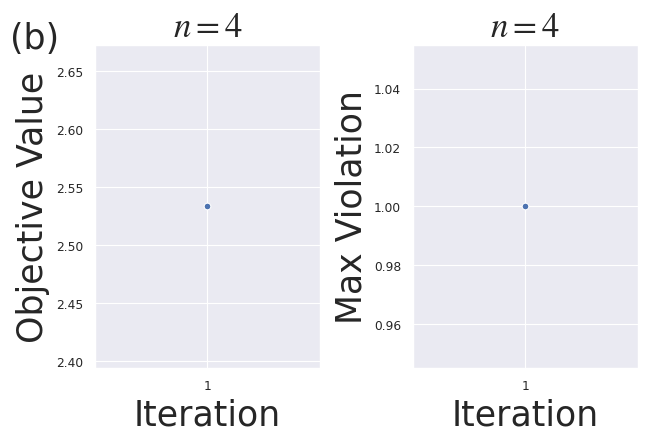

n=5
CG: n=5, K=0.01, method='mosek'
start: calculate dots
[k|progress|range]: 1 | 2.01600e+03/2.42352e+06 | [0.00341, 0.43844] | 11[ms]
[k|progress|range]: 2 | 4.16960e+04/2.42352e+06 | [0.25628, 0.52831] | 26[ms]
[k|progress|range]: 3 | 3.59136e+05/2.42352e+06 | [0.35676, 0.58822] | 37[ms]
[k|progress|range]: 4 | 1.37494e+06/2.42352e+06 | [0.40539, 0.61861] | 45[ms]
[k|progress|range]: 5 | 2.42352e+06/2.42352e+06 | [0.42521, 0.61861] | 76[ms]
 calculation time : 76[ms]
branch cut / total: 375296/2423520
iteration: 1 / 100, Amat.shape = (32, 5000)
start: solve SOCP
stabilizer_extent=3.435324038419822
start: calculate dual dots
[k|progress|range]: 1 | 2.01600e+03/2.42352e+06 | [nan, nan] | 11[ms]
[k|progress|range]: 2 | 4.16960e+04/2.42352e+06 | [nan, nan] | 16[ms]
[k|progress|range]: 3 | 3.59136e+05/2.42352e+06 | [nan, nan] | 20[ms]
[k|progress|range]: 4 | 1.37494e+06/2.42352e+06 | [nan, nan] | 25[ms]
[k|progress|range]: 5 | 2.42352e+06/2.42352e+06 | [nan, nan] | 36[ms]
 calculation ti

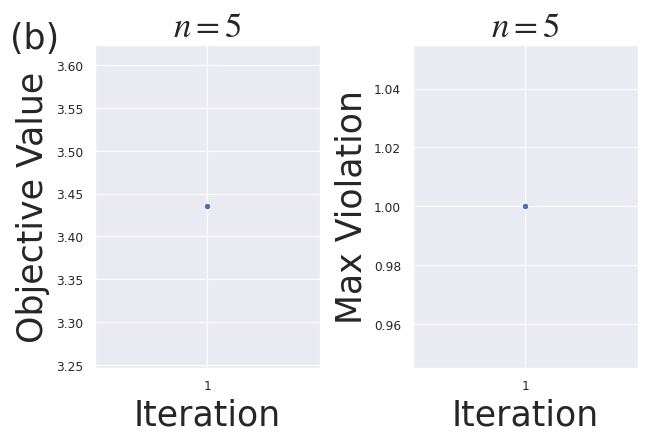

n=6
CG: n=6, K=0.01, method='mosek'
start: calculate dots
[k|progress|range]: 1 | 8.12800e+03/3.15058e+08 | [0.08328, 0.46929] | 20[ms]
[k|progress|range]: 2 | 3.41440e+05/3.15058e+08 | [0.26840, 0.47587] | 61[ms]
[k|progress|range]: 3 | 6.05536e+06/3.15058e+08 | [0.34155, 0.47761] | 117[ms]
[k|progress|range]: 4 | 4.87193e+07/3.15058e+08 | [0.37664, 0.50896] | 168[ms]
[k|progress|range]: 5 | 1.80840e+08/3.15058e+08 | [0.39381, 0.50896] | 282[ms]
[k|progress|range]: 6 | 3.15058e+08/3.15058e+08 | [0.40049, 0.50896] | 711[ms]
 calculation time : 711[ms]
branch cut / total: 281453568/315057600
iteration: 1 / 100, Amat.shape = (64, 5000)
start: solve SOCP
stabilizer_extent=5.010393567165563
start: calculate dual dots
[k|progress|range]: 1 | 8.12800e+03/3.15058e+08 | [nan, nan] | 15[ms]
[k|progress|range]: 2 | 3.41440e+05/3.15058e+08 | [nan, nan] | 21[ms]
[k|progress|range]: 3 | 6.05536e+06/3.15058e+08 | [1.00210, 1.00210] | 29[ms]
[k|progress|range]: 4 | 4.87193e+07/3.15058e+08 | [1.00062,

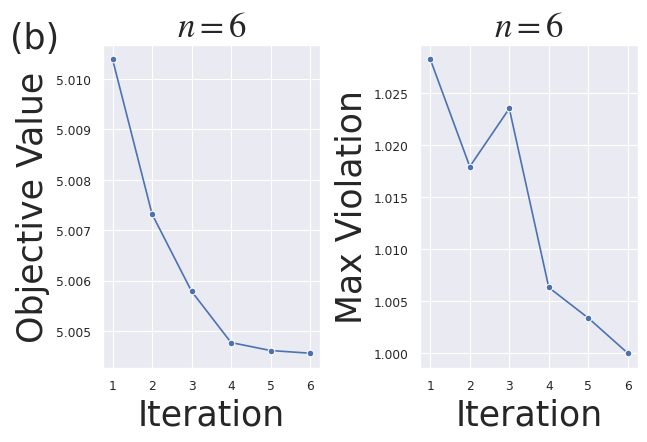

n=7
CG: n=7, K=0.01, method='mosek'
start: calculate dots
[k|progress|range]: 1 | 3.26400e+04/8.12849e+10 | [0.12146, 0.24450] | 57[ms]
[k|progress|range]: 2 | 2.76365e+06/8.12849e+10 | [0.21587, 0.30041] | 170[ms]
[k|progress|range]: 3 | 9.95194e+07/8.12849e+10 | [0.26866, 0.35288] | 390[ms]
[k|progress|range]: 4 | 1.64761e+09/8.12849e+10 | [0.30492, 0.37722] | 972[ms]
[k|progress|range]: 5 | 1.28338e+10/8.12849e+10 | [0.32877, 0.39696] | 2900[ms]
[k|progress|range]: 6 | 4.69251e+10/8.12849e+10 | [0.34263, 0.40907] | 6488[ms]
[k|progress|range]: 7 | 8.12849e+10/8.12849e+10 | [0.34818, 0.40907] | 8918[ms]
 calculation time : 8918[ms]
branch cut / total: 80906708992/81284860800
iteration: 1 / 100, Amat.shape = (128, 5000)
start: solve SOCP
stabilizer_extent=7.557388018452466
start: calculate dual dots
[k|progress|range]: 1 | 3.26400e+04/8.12849e+10 | [nan, nan] | 13[ms]
[k|progress|range]: 2 | 2.76365e+06/8.12849e+10 | [nan, nan] | 24[ms]
[k|progress|range]: 3 | 9.95194e+07/8.12849e+10 

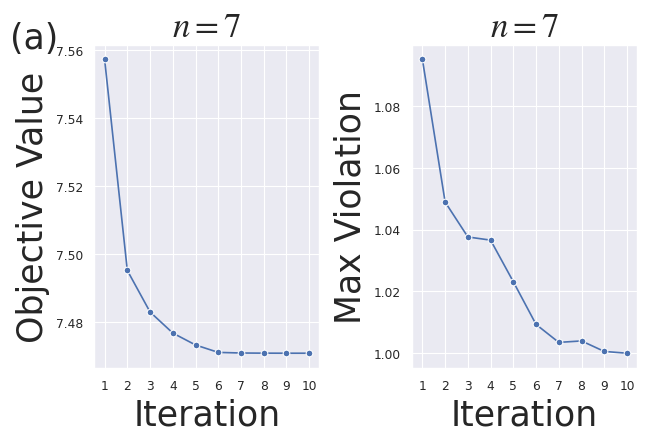

In [10]:
import time

for n in [4, 5, 6, 7]:  # , 8]:
    print("=" * 20)
    print(f"{n=}")
    np.random.seed(seed)
    psi = make_random_quantum_state("pure", n, seed)
    t0 = time.perf_counter()
    stabilizer_extent, extends, max_values = CG(n, psi, 0.01)
    t1 = time.perf_counter()
    print(f"{stabilizer_extent=} {t1-t0=}")
    visualize_result(n, extends, max_values)